## このパートではVSFLOWを利用してバーチャルスクリーニングに使う機能を試します。
- [VSFlow](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00703-1) はLBDD用のコマンドラインツールです
- Czodrowski氏のラボはこれ以外にも有用なパッケージを多数公開していますので、興味がありましたらチェックしましょう。
- [github repo](https://github.com/czodrowskilab/VSFlow)
- 以下の例ではPDBリガンドを使いますが、各自任意のデータからデータベースを作ることも可能です。
- Chembl, pdbのデータはダウンロードすることが可能で以下のコマンドでデータを取得できます。
```
$ vsflow preparedb --download pdb * ligand expoからデータ取得
$ vsflow preparedb --download chembl * chembl ftpからVer28をDL（少し古いので注意）
$ vsflow preparedb -i yourdata.sdf
```

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.TemplateAlign import AlignMolToTemplate2D
from rdkit.Chem import rdDepictor
import pandas as pd
IPythonConsole.drawOptions.comicMode = True
rdDepictor.SetPreferCoordGen(True)
#IPythonConsole.InteractiveRenderer.setEnabled()
import subprocess

# Substructure Search
### まずはじめに部分構造検索を行いましょう。
- [ref](https://github.com/czodrowskilab/VSFlow/wiki/3-Substructure-Search)
- 下の例では一つしかクエリを与えていませんが、複数のクエリを一回の検索で投げることも可能です。

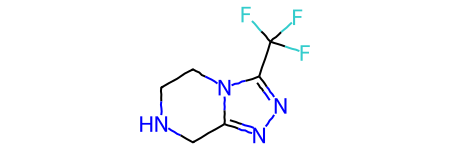

In [2]:
query = "N3Cc2nnc(n2CC3)C(F)(F)F"
qm = Chem.MolFromSmiles(query)
rdDepictor.Compute2DCoords(qm)
pc = qm.GetConformer(0)
qm

### VSFLOWはCLI ToolのためJupyterから本来利用しません。今回は出力データの確認をJupyter上から行うためSubprocessを利用しつつVSFLOWを実行します。
- この下のセルで実施されるコードはShellでは以下のコードと等価です。
```bash
$ vsflow substructure -smi "N3Cc2nnc(n2CC3)C(F)(F)F" -d ./pdb_ligs.vsdb
```

In [3]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb'
])

/home/iwatobipen/miniconda3/envs/cbi2023/bin/vsflow:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('vsflow==1.0.2')


**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/01/2023, 17:59:59
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.02093 seconds
Generating output file(s) ...
4 matches found
Finished: 10/01/2023, 18:00:00
Finished in 1.0232 seconds


0

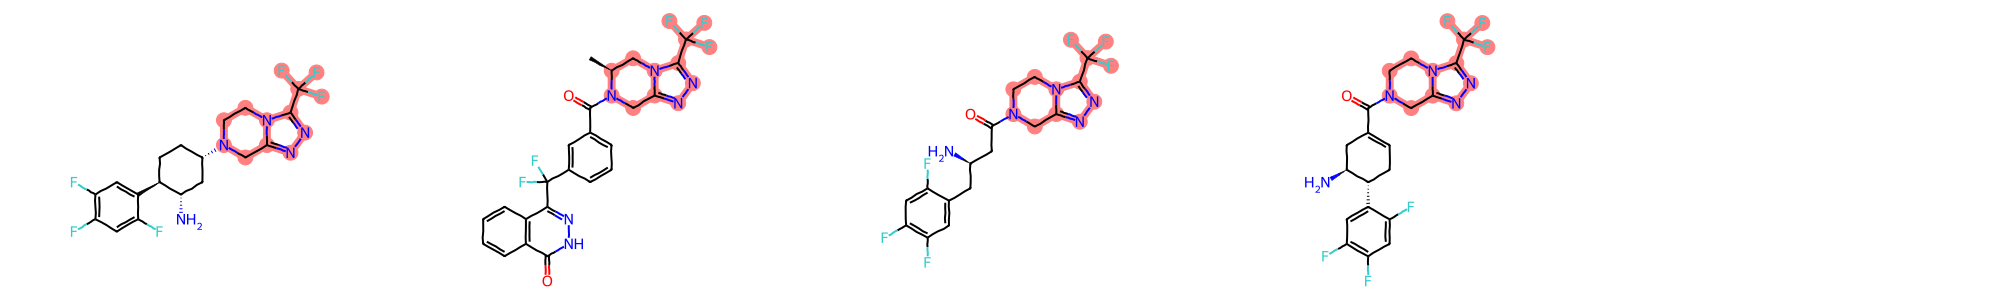

In [4]:
hits = Chem.SDMolSupplier('./substructure.sdf')
mols = [m for m in hits]
highlightAtomLists = []
for m in mols:    
    matchatms = m.GetSubstructMatches(qm)
    # GenerateDepictionMatching2DStructureを使うとテンプレートにアライメントできます。SARデータの可視化の際に便利ですね。
    rdDepictor.GenerateDepictionMatching2DStructure(m, qm, confId=0)
    res = []
    for match in matchatms:
        for atm in match:
            res.append(atm)
    highlightAtomLists.append(res)
Draw.MolsToGridImage(mols, highlightAtomLists=highlightAtomLists, molsPerRow=5, subImgSize=(400,300))

### pdf option
- --pdfオプションを付与することで部分構造マッチ部分をハイライトしたサマリーをPDFとして出力することが可能です。
- -o の引数としてxlsxファイルを指定することでエクセルへの出力ができます。WindwosPCではエクセルを利用するツールも多いので便利なオプションかもしれません。

In [5]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './substructure.xlsx',
    '--pdf',
    '-p'
])

/home/iwatobipen/miniconda3/envs/cbi2023/bin/vsflow:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('vsflow==1.0.2')


**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/01/2023, 18:00:01
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.06423 seconds
Generating output file(s) ...
4 matches found
Generating PDF file(s) ...
Finished: 10/01/2023, 18:00:02
Finished in 1.18765 seconds


0

In [6]:
df = pd.read_excel('./substructure.xlsx')
df

,Smiles,ligand_id,name,QuerySmiles,MW (g/mol),cLogP,TPSA (A²),HDon,HAcc,RotBonds,AromRings,HetAromRings
0,N[C@H]1C[C@@H](N2CCn3c(nnc3C(F)(F)F)C2)CC[C@@H...,417,"(1s,2r,5s)-5-[3-(trifluoromethyl)-5,6-dihydro[...",N3Cc2nnc(n2CC3)C(F)(F)F,419.37,3.19,59.97,1,5,2,2,1
1,C[C@H]1Cn2c(nnc2C(F)(F)F)CN1C(=O)c1cccc(C(F)(F...,5N8,4-[bis(fluoranyl)-[3-[[(6~{s})-6-methyl-3-(tri...,N3Cc2nnc(n2CC3)C(F)(F)F,504.42,3.72,96.77,1,6,3,4,2
2,N[C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1cc(F)...,715,"(2r)-4-oxo-4-[3-(trifluoromethyl)-5,6-dihydro[...",N3Cc2nnc(n2CC3)C(F)(F)F,407.32,2.02,77.04,1,5,4,2,1
3,N[C@H]1CC(C(=O)N2CCn3c(nnc3C(F)(F)F)C2)=CC[C@@...,KIQ,"(1s,6r)-3-{[3-(trifluoromethyl)-5,6-dihydro[1,...",N3Cc2nnc(n2CC3)C(F)(F)F,445.37,2.89,77.04,1,5,2,2,1


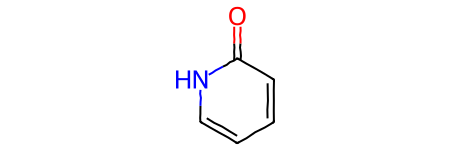

In [7]:
query2 = "C1=CC=CNC(=O)1"
Chem.MolFromSmiles(query2)

In [19]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query2,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './substructure_2.sdf'
])

/home/iwatobipen/miniconda3/envs/cbi2023/bin/vsflow:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('vsflow==1.0.2')


**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/01/2023, 17:59:34
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.1989 seconds
Generating output file(s) ...
735 matches found
Finished: 10/01/2023, 17:59:36
Finished in 1.49225 seconds


0

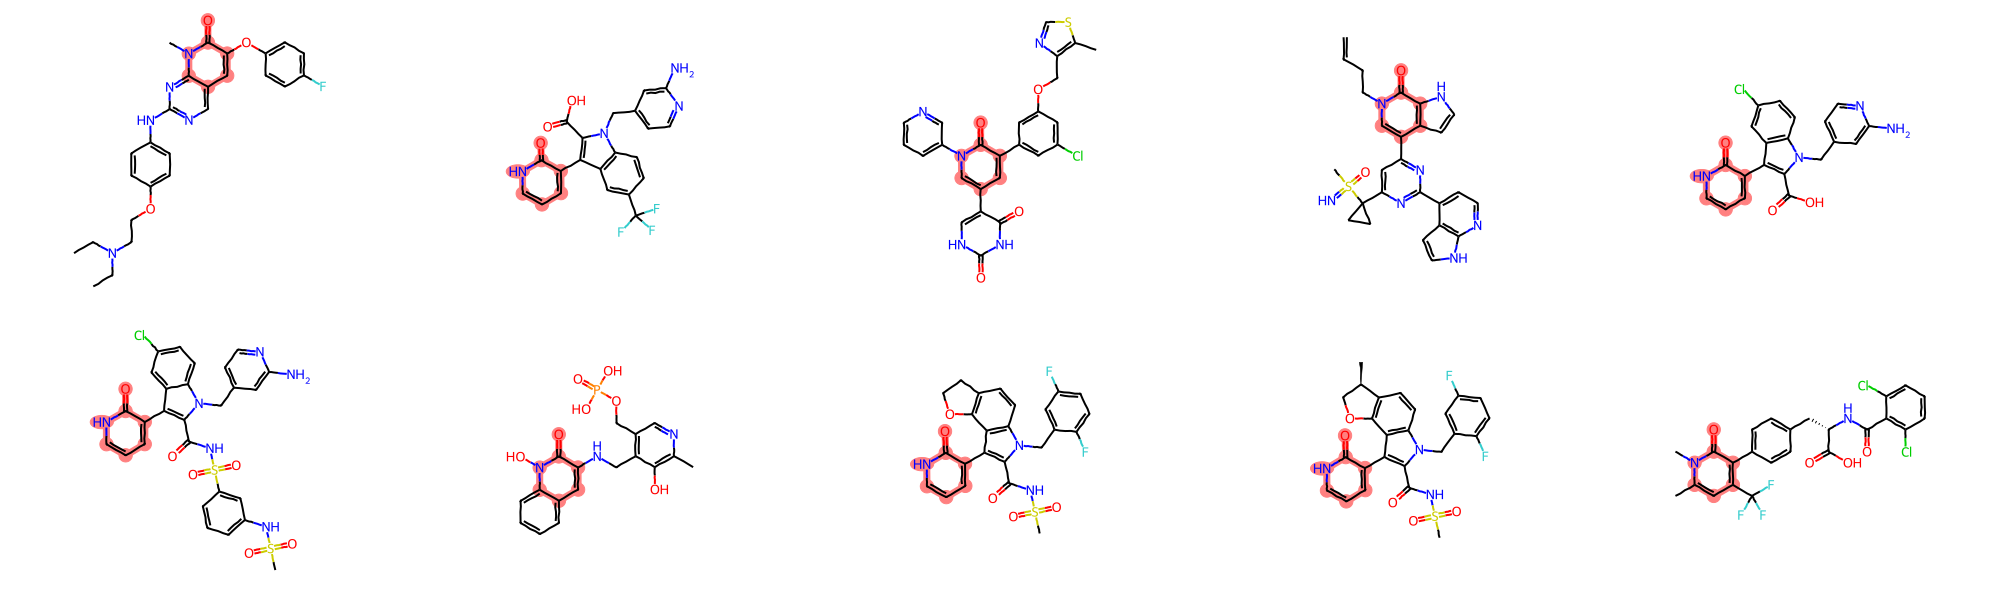

In [21]:
hits2 = Chem.SDMolSupplier('./substructure_2.sdf')
qm2 = Chem.MolFromSmiles(query2)
rdDepictor.Compute2DCoords(qm2)
mols = [m for m in hits2][:10]
highlightAtomLists = []
for m in mols:    
    matchatms = m.GetSubstructMatches(qm2)
    #GenerateDepictionMatching2DStructureを使うとテンプレートにアライメントできます。SARデータの可視化の際に便利ですね。
    rdDepictor.GenerateDepictionMatching2DStructure(m, qm2)
    res = []
    for match in matchatms:
        for atm in match:
            res.append(atm)
    highlightAtomLists.append(res)
Draw.MolsToGridImage(mols, highlightAtomLists=highlightAtomLists, molsPerRow=5, subImgSize=(400,300))

### -m option
- mode オプションを付与することでTautomerを加味した検索の実施が可能です。
- -m all_tautsとするとデフォルトで最大100件までクエリ構造からTautomerを発生し検索をかけます。
- -m can_tautは各ツール毎に異なるTautmerの表現揺れに対する対策として有用です。

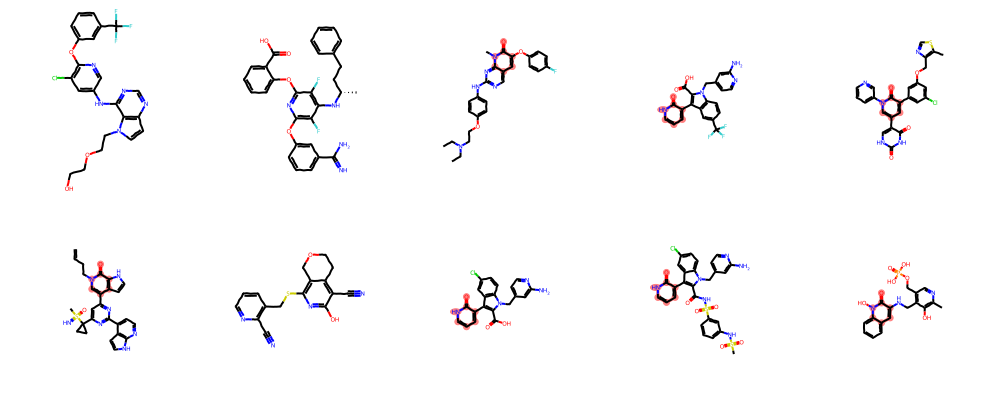

In [22]:
hits3 = Chem.SDMolSupplier('./substructure_3.sdf')
qm2 = Chem.MolFromSmiles(query2)
rdDepictor.Compute2DCoords(qm2)
mols = [m for m in hits3][:10]
highlightAtomLists = []
for m in mols:    
    matchatms = m.GetSubstructMatches(qm2)
    #GenerateDepictionMatching2DStructureを使うとテンプレートにアライメントできます。SARデータの可視化の際に便利ですね。
    try:
        rdDepictor.GenerateDepictionMatching2DStructure(m, qm2)
    except:
        pass
    res = []
    for match in matchatms:
        for atm in match:
            res.append(atm)
    highlightAtomLists.append(res)
Draw.MolsToGridImage(mols, highlightAtomLists=highlightAtomLists, molsPerRow=5)

In [13]:
subprocess.call(
[
    'vsflow',
    'substructure',
    '-smi',
    query2,
    '-d',
    './pdb_ligs.vsdb',
    '-m',
    'all_tauts',
    '-o',
    './substructure_3.sdf'
])

/home/iwatobipen/miniconda3/envs/cbi2023/bin/vsflow:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('vsflow==1.0.2')


**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/01/2023, 18:04:50
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query ...
Finished substructure search in 1.384 seconds
Generating output file(s) ...
1075 matches found
Finished: 10/01/2023, 18:04:52
Finished in 1.82469 seconds


0

## 上の例では2ヒドロキシピリジンも部分構造としてヒットしたので構造に含まれています。

# Similarity Search
### 次は類似構造検索を実施してみます。
- [ref](https://github.com/czodrowskilab/VSFlow/wiki/4-Fingerprint-Similarity)
- 類似構造検索をするコマンドはvsflow fpsimです。
- 下の例では一つしかクエリを与えていませんが、複数のクエリを一回の検索で投げることも可能です。
- -tオプションでヒットの上位何件を出力するかをしてきます。デフォルトは10なので結果は10件帰ってきます。
- fingeprintは、fcfp, ecfp, rdit, ap, tt, maccsの中から任意のものを利用できます。デフォルトはfcfpに設定されています。

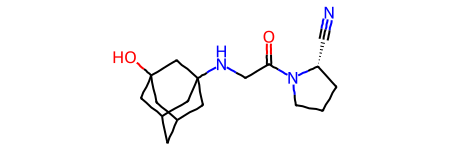

In [23]:
query = 'N#C[C@H]4N(C(=O)CNC13CC2CC(C1)CC(O)(C2)C3)CCC4'
Chem.MolFromSmiles(query)

In [24]:
subprocess.call(
[
    'vsflow',
    'fpsim',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '-o',
    './sim_search_res.sdf'
])

/home/iwatobipen/miniconda3/envs/cbi2023/bin/vsflow:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('vsflow==1.0.2')


**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/01/2023, 18:10:31
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query input ...
Calculating fingerprints ...
Finished fingerprint generation in 9.14882 seconds
Calculating similarities ...
Finished calculating similarities in 0.14358 seconds
Writing 10 molecules to output file(s)
Generating output file(s) ...
Finished: 10/01/2023, 18:10:41
Finished in 10.53944 seconds


0

In [25]:
sim_hits = [m for m in Chem.SDMolSupplier('./sim_search_res.sdf')]

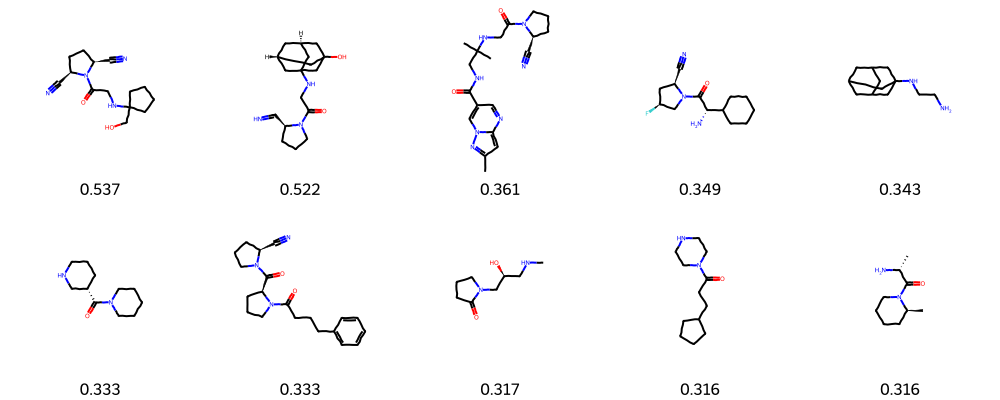

In [27]:
Draw.MolsToGridImage(sim_hits, molsPerRow=5,
                    legends=[f"{float(m.GetProp('TanimotoSimilarity')):.3f}" for m in sim_hits])

In [34]:
### 部分構造検索のときと同様にPDFに結果を出力できます。

In [28]:
subprocess.call(
[
    'vsflow',
    'fpsim',
    '-smi',
    query,
    '-d',
    './pdb_ligs.vsdb',
    '--pdf',
    '-o',
    './sim_search_res.sdf'
])

/home/iwatobipen/miniconda3/envs/cbi2023/bin/vsflow:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('vsflow==1.0.2')


**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/01/2023, 18:11:30
Running in single core mode
Loading database ./pdb_ligs.vsdb ...
Reading query input ...
Calculating fingerprints ...
Finished fingerprint generation in 9.23458 seconds
Calculating similarities ...
Finished calculating similarities in 0.1424 seconds
Writing 10 molecules to output file(s)
Generating output file(s) ...
Generating PDF file(s) ...
Finished: 10/01/2023, 18:11:41
Finished in 10.83643 seconds


0

# Shape-based Screening
### 分子形状に着目したスクリーニング
- [ref](https://github.com/czodrowskilab/VSFlow/wiki/5-Shape-Screening)
- VSFlowには、クエリー分子とデータベース分子間の形状の類似性に基づいて化合物データベースをスクリーニングするツールが含まれています。これを利用するためには、データベースが3次元情報を持つ分子を含んでいなければならない。クエリー分子は2Dでも3DでもOKです。クエリーが2Dの場合、VSFlowは各クエリー分子について、エネルギー最小化された3Dコンフォーマーを1つ（必要であれば複数）生成します。必要であれば、VSFlowの "prepareb "機能を使ってデータベース分子のコンフォーマーを生成することができます。
- 例えば以下のようなオプションが指定できます。
 - -o 出力ファイルの名前 
 - -np 実行する際に利用するコア数
 - -t Top何個のヒットを返すか
 - -s ランキングに利用するスコアの指定 (shapre, pharmacophore, combo)
 - --nconfs クエリが2Dだった場合配座を何個発生し探索するか（デフォルトは100）
 - --pymol Pymolセッションファイルを生成する
- 以下のコマンドはShape Screenを8並列で行う例です。

In [30]:
# Subprocessではうまく動作しないので、ここはコマンドで実行します。
!vsflow shape -i XED.sdf -d fda_multiple_confs.vsdb -o XED_shapesim --pymol -np 8

/home/iwatobipen/miniconda3/envs/cbi2023/bin/vsflow:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('vsflow==1.0.2')
**************************

 VV        VV  SSSSSSS             VSFlow   
  VV      VV  SSS    SS       Virtual Screening
   VV    VV    SSSS               Workflow
    VV  VV       SSSS         
     VVVV     SS    SSS       
      VV       SSSSSSS           

**************************

Start: 10/01/2023, 18:15:44
Running in parallel mode on 8 threads
Reading database ...
Reading query ...
Performing shape screening ...
Finished shape screening in 234.73572 seconds
Filtering and sorting results...
Writing results to output files...
Generating PyMOl file ...
Finished: 10/01/2023, 18:19:39
Finished in 235.01213 seconds


### 以上ここまでのチュートリアルにてVSFLOWを利用した類似構造検索、部分構造検索、Shape Screeningを行う方法について説明しました。